In [25]:
import itertools
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.calibration import LinearSVC
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import StandardScaler


# Different feature selection methods
import sklearn.feature_selection as fs

# DF initialization
unrelaxed_df = pd.read_csv('data/SrTiO3ASiteUpFullGrid.csv')

# Separate features, SCF/SCF Shift, and X/Y
features = unrelaxed_df.iloc[:, 4:]
scfShift = unrelaxed_df.iloc[:, 3:4]
SCF = unrelaxed_df.iloc[:, 2:3]
xy = unrelaxed_df.iloc[:, :2]

#normalize SCF using standard scaler
scaler = StandardScaler()
scaler.fit(SCF)
SCF = scaler.transform(SCF)

#convert scfShift to 1D np array of floats
scfShift = scfShift.values.ravel().reshape(-1,1)

#convert scfShift to csv
# np.savetxt("scfShift.csv", scfShift, delimiter=",")

In [14]:
#NON NORMALIZED DATA

def perform_clustering_nonnorm(features, scfShift, algorithm_index, n_clusters):
    # Generate combinations of variables
    variable_combinations = list(itertools.combinations(features.columns, 2))
    total_combinations = len(variable_combinations)

    # Select the algorithm based on the given index
    algorithms = [LinearSVC(), KMeans(n_clusters=n_clusters)]
    algorithm = algorithms[algorithm_index]

    # Initialize an empty list to store results
    result_list = []

    # Perform clustering on each combination of variables
    for i, combination in enumerate(variable_combinations):
        variables = features[list(combination)]

        # Fit the clustering algorithm to the features
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            algorithm.fit(variables)

        # Overlay clusters on scfShift data
        labels = algorithm.labels_
        score = silhouette_score(scfShift, labels)

        # Store the results in the list
        result_list.append({'Variable 1': combination[0],
                            'Variable 2': combination[1],
                            'Silhouette Score': score})

        # Update progress
        progress = (i + 1) / total_combinations * 100
        sys.stdout.write('\r')
        sys.stdout.write(f"Clustering Progress: [{progress:.1f}%] ")
        sys.stdout.flush()

    # Convert the list to a DataFrame
    result_df = pd.DataFrame(result_list)

    # Sort the DataFrame by silhouette score in descending order
    result_df = result_df.sort_values(by='Silhouette Score', ascending=False)

    # Select the top 100 variables
    top_100_variables = result_df.head(100)

    #convert top 100 variables to csv named "top100nonnorm.csv"
    top_100_variables.to_csv('top100nonnorm.csv')

    return top_100_variables


# Example usage
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    top_variables = perform_clustering_nonnorm(features, scfShift, 1, 4)

#save top variables to a csv file named "oxygen_abs_top_var.csv"
top_variables.to_csv('oxygen_abs_top_var_4_nonnorm.csv')

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    top_variables = perform_clustering_nonnorm(features, scfShift, 1, 3)

top_variables.to_csv('oxygen_abs_top_var_3_nonnorm.csv')

print(top_variables)

Clustering Progress: [100.0%]             Variable 1        Variable 2  Silhouette Score
7874  G5-4  R_cut = 12  G5-5  R_cut = 12          0.638951
1088    G3-3 R_cut = 7  G5-5  R_cut = 12          0.638951
1086    G3-3 R_cut = 7  G5-3  R_cut = 12          0.638951
6963   G4-4  R_cut = 9  G4-3  R_cut = 12          0.638951
1082    G3-3 R_cut = 7  G4-5  R_cut = 12          0.638951
...                ...               ...               ...
1039    G3-3 R_cut = 7   G5-4  R_cut = 8          0.638951
1038    G3-3 R_cut = 7   G5-3  R_cut = 8          0.638951
6933   G4-4  R_cut = 9   G5-3  R_cut = 9          0.638951
5907   G5-2  R_cut = 7  G5-3  R_cut = 11          0.638951
6929   G4-4  R_cut = 9   G4-5  R_cut = 9          0.638951

[100 rows x 3 columns]


In [16]:
#NORMALIZED DATA

def perform_clustering_norm(features, scfShift, algorithm_index,n_clusters):
    # Generate combinations of variables
    variable_combinations = list(itertools.combinations(features.columns, 2))
    total_combinations = len(variable_combinations)

    # Select the algorithm based on the given index
    algorithms = [LinearSVC(), KMeans(n_clusters=n_clusters)]
    algorithm = algorithms[algorithm_index]

    # Initialize an empty list to store results
    result_list = []

    # Normalize the feature and scfShift data
    scaler = StandardScaler()
    scaled_features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    scaled_scfShift = scaler.fit_transform(scfShift)

    # Perform clustering on each combination of variables
    for i, combination in enumerate(variable_combinations):
        variables = scaled_features[list(combination)]

        # Fit the clustering algorithm to the data
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            algorithm.fit(variables)

        # Overlay clusters on scaled scfShift data
        labels = algorithm.labels_
        score = silhouette_score(scaled_scfShift, labels)

        # Store the results in the list
        result_list.append({'Variable 1': combination[0],
                            'Variable 2': combination[1],
                            'Silhouette Score': score})

        # Update progress
        progress = (i + 1) / total_combinations * 100
        sys.stdout.write('\r')
        sys.stdout.write(f"Clustering Progress: [{progress:.1f}%] ")
        sys.stdout.flush()

    # Convert the list to a DataFrame
    result_df = pd.DataFrame(result_list)

    # Sort the DataFrame by silhouette score in descending order
    result_df = result_df.sort_values(by='Silhouette Score', ascending=False)

    # Select the top 100 variables
    top_100_variables = result_df.head(100)

    #convert top 100 variables to csv named "top100norm.csv"
    top_100_variables.to_csv('top100norm.csv')

    return top_100_variables


# Example usage
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    top_variables = perform_clustering_norm(features, scfShift, 1, 4)

#save top variables to a csv file named "oxygen_abs_top_var.csv"
top_variables.to_csv('oxygen_abs_top_var_4_norm.csv')

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    top_variables = perform_clustering_norm(features, scfShift, 1, 3)

top_variables.to_csv('oxygen_abs_top_var_3_norm.csv')

print(top_variables)


Clustering Progress: [100.0%]            Variable 1        Variable 2  Silhouette Score
0           G1 - r= 7    G2-0 R_cut = 7          0.638951
4205  G2-2 R_cut = 11  G5-3  R_cut = 11          0.638951
4150  G2-2 R_cut = 11   G4-2  R_cut = 7          0.638951
4163  G2-2 R_cut = 11   G4-3  R_cut = 8          0.638951
4169  G2-2 R_cut = 11   G5-3  R_cut = 8          0.638951
...               ...               ...               ...
3477  G2-3 R_cut = 10  G5-3  R_cut = 10          0.638951
3704  G3-2 R_cut = 10   G3-0 R_cut = 12          0.638951
3690  G3-2 R_cut = 10        G1 - r= 11          0.638951
3691  G3-2 R_cut = 10   G2-0 R_cut = 11          0.638951
3692  G3-2 R_cut = 10   G2-1 R_cut = 11          0.638951

[100 rows x 3 columns]


In [3]:
top_feat = ['G4-3  R_cut = 8', 'G5-5  R_cut = 11']


with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    top_variables_SVC = perform_clustering_norm(features, scfShift, 0)

print(top_variables_SVC)

NameError: name 'warnings' is not defined

c:\Users\zayah\OneDrive\Desktop\AndereussiLabWork\SEEDworks\SrRuO3MatTesting\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


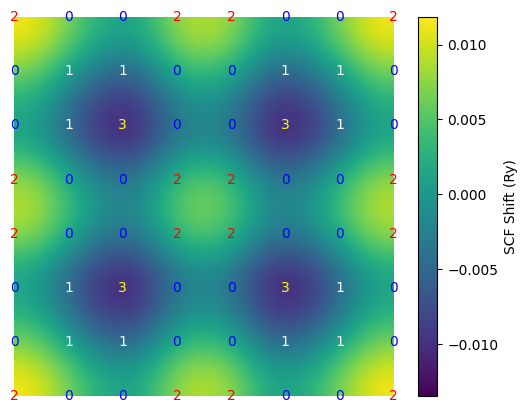

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Create a DataFrame with the variables from top_feat
variables_df = unrelaxed_df[['G4-3  R_cut = 8', 'G5-5  R_cut = 11']]

# Perform clustering
kmeans = KMeans(n_clusters=4)  # Set the desired number of clusters
kmeans.fit(variables_df)

# Assign cluster labels to each index of the SCF values
cluster_labels = kmeans.labels_

# Obtain the scfShift values
scf_shift_values = unrelaxed_df['SCFshift']

# Generate x and y values
x_values = np.linspace(0, 7.8254, 8)  # Adjusted to match the number of points in the original code
y_values = np.linspace(0, 7.8254, 8)  # Adjusted to match the number of points in the original code

# Generate all combinations of x and y coordinates
coordinates = [(x, y) for x in x_values for y in y_values]

# Create a colormap plot based on scfShift values
plt.imshow(scf_shift_values.values.reshape(8, 8), cmap='viridis', extent=[0, 7.8254, 0, 7.8254], origin='lower', interpolation='bicubic')

# Add cluster numbers as text annotations at the center of each coordinate
for i, coord in enumerate(coordinates):
    if cluster_labels[i] == 0:
        plt.text(coord[0], coord[1], str(cluster_labels[i]), ha='center', va='center', color='blue')
    elif cluster_labels[i] == 1:
        plt.text(coord[0], coord[1], str(cluster_labels[i]), ha='center', va='center', color='white')
    elif cluster_labels[i] == 2:
        plt.text(coord[0], coord[1], str(cluster_labels[i]), ha='center', va='center', color='red')
    elif cluster_labels[i] == 3:
        plt.text(coord[0], coord[1], str(cluster_labels[i]), ha='center', va='center', color='yellow')

# Remove x and y axis
plt.axis('off')

colorbar = plt.colorbar()
colorbar.ax.set_ylabel('SCF Shift (Ry)')

# Adjust the spacing between the plot and the title
plt.subplots_adjust(top=0.9)

# Display the plot
plt.show()


c:\Users\zayah\OneDrive\Desktop\AndereussiLabWork\SEEDworks\SrRuO3MatTesting\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\zayah\OneDrive\Desktop\AndereussiLabWork\SEEDworks\SrRuO3MatTesting\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\zayah\OneDrive\Desktop\AndereussiLabWork\SEEDworks\SrRuO3MatTesting\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c

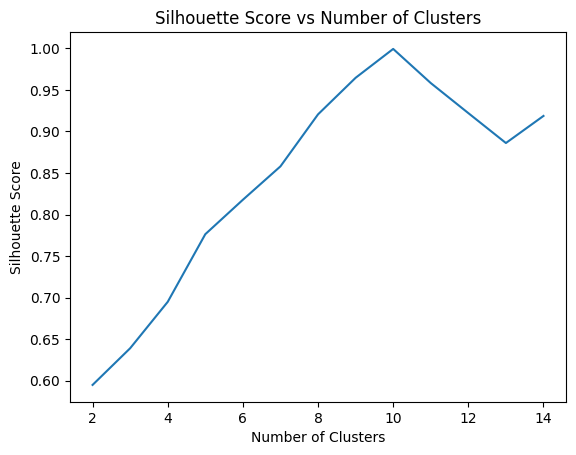

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Import the data from CSV
data = pd.read_csv('scfShift.csv', header=None)
scfShift = data.iloc[:, 0].values

# Check the number of unique values
unique_values = np.unique(scfShift)
num_unique = len(unique_values)

if num_unique < 2:
    print("Error: Number of unique values is less than 2. Check your data.")
    exit()

# Perform clustering and calculate silhouette scores
silhouette_scores = []
clusters = range(2, min(num_unique, 15))

for n_clusters in clusters:
    # Fit the K-means model
    kmeans = KMeans(max_iter=100, n_clusters=n_clusters)
    kmeans.fit(scfShift.reshape(-1, 1))

    # Predict cluster labels
    labels = kmeans.predict(scfShift.reshape(-1, 1))

    # Calculate silhouette score
    score = silhouette_score(scfShift.reshape(-1, 1), labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.plot(clusters, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()
